# 1) Importing Necessary Packages & Libraries

In [20]:
import keras
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time
import cv2
from PIL import Image
from tqdm import tqdm
from IPython import display
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam,SGD

Defining a function to automaticaly resize, reshape and normalize the use-case images.

In [21]:
def Dataset_loader(DIR,RESIZE):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img)/255.)
    return IMG

# Read and Import the dataset in 32 * 32 dimensions

In [22]:
benign_train = np.array(Dataset_loader('../input/skin-cancer-malignant-vs-benign/train/benign',32))
malignant_train = np.array(Dataset_loader('../input/skin-cancer-malignant-vs-benign/train/malignant',32))
benign_test = np.array(Dataset_loader('../input/skin-cancer-malignant-vs-benign/test/benign',32))
malignant_test = np.array(Dataset_loader('../input/skin-cancer-malignant-vs-benign/test/malignant',32))

100%|██████████| 300/300 [00:01<00:00, 260.09it/s]


In [23]:
benign_train_label = np.zeros(len(benign_train))
malig_train_label = np.ones(len(malignant_train))
benign_test_label = np.zeros(len(benign_test))
malig_test_label = np.ones(len(malignant_test))

In [24]:
X_train = np.concatenate((benign_train, malignant_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malig_train_label), axis = 0)
X_test = np.concatenate((benign_test, malignant_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malig_test_label), axis = 0)

In [25]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [26]:
X_train.shape, Y_train.shape

((2637, 32, 32, 3), (2637,))

In [27]:
img_rows = 32
img_cols = 32
channels = 3
        
img_shape = (img_rows, img_cols, channels)        
latent_dim = 2637

# Build a Generator Model to generate images

In [28]:
def build_generator():

        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
        model.add(Reshape((8, 8, 128)))
        
        model.add(UpSampling2D())#upsamples to 16*16*128
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(UpSampling2D()) #upsamples to 32*32*128
        
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(Conv2D(channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        #outputs an image of 32*32*3

        noise = Input(shape=(latent_dim,))
        img = model(noise)

        return Model(noise, img)

# Build a Discriminator model to verify and check images generated by Generator model

In [29]:
def build_discriminator():

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        #no normalization for the first layer 
        
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)


In [30]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
            optimizer=Adam(0.0002,0.5),
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

In [31]:
def show_imgs(epoch):
        r, c = 4,4
        noise = np.random.normal(0, 1, (r * c,latent_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

In [32]:
def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()

0 [D loss: 1.076842] [G loss: 0.943394]


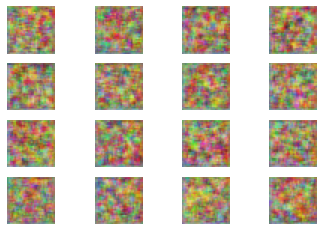

5000 [D loss: 0.473094] [G loss: 2.074655]


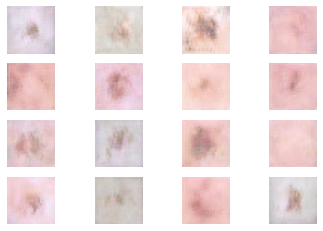

10000 [D loss: 0.395411] [G loss: 2.101745]


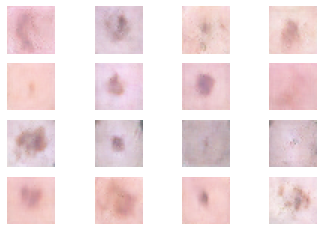

In [ ]:
epochs=30000
batch_size=32
display_interval=5000
losses=[]  # Call an empty list 
        

# Adversarial ground truths
valid = np.ones((batch_size, 1))
        #let's add some noise 
valid += 0.05 * np.random.random(valid.shape)
fake = np.zeros((batch_size, 1))
fake += 0.05 * np.random.random(fake.shape)

for epoch in range(epochs):
    
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

            # Sample noise and generate a batch of new images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(noise)
            

            # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            
            #  Train Generator
            

            # Train the generator (wants discriminator to mistake images as real)
    g_loss = combined.train_on_batch(noise, valid)
            
            # Plot the progress
    if epoch % 5000==0:
        print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
        if epoch % 1000==0:
            losses.append((d_loss[0],g_loss))
                
            if epoch % display_interval == 0:
                show_imgs(epoch)


In [ ]:
show_losses(losses)

Generator generated images 

In [ ]:
s=X_train[:40]
s = 0.5 * s + 0.5
f, ax = plt.subplots(5,8, figsize=(16,10))
for i, img in enumerate(s):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
        
plt.show()

SAMPLE Images produced by the Generator model after training for 30000 epochs

In [ ]:
noise = np.random.normal(size=(40, latent_dim))
generated_images = generator.predict(noise)
generated_images = 0.5 * generated_images + 0.5
f, ax = plt.subplots(5,8, figsize=(16,10))
for i, img in enumerate(generated_images):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
        
plt.show()